In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

workding_dir = str(Path.cwd().parent)
os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

workding dir: /Users/inflaton/code/engd/papers/maritime/global-incidents
loading env vars from: /Users/inflaton/code/engd/papers/maritime/global-incidents/.env


True

## Import

In [4]:
%%capture

!python -m spacy download en_core_web_sm

In [5]:
import spacy
import pandas as pd
import numpy as np
import re

nlp = spacy.load("en_core_web_sm")

df = pd.read_csv("data/cleaned_data.csv")
df = df[df["Headline"].apply(lambda x: not isinstance(x, float))]
df.head()

id                                           Headline  \
0  1.0  Grasberg Mine- Grasberg mine workers extend st...   
1  2.0  Indonesia: Undersea internet cables damaged by...   
2  3.0  Shanghai port congestion impacts terminals in ...   
3  4.0  UPDATE - Indonesia: Explosion at KP Terminal i...   
4  5.0  UPDATE - Indonesia: Police confirm two explosi...   

                                             Details  Severity  \
0  Media sources indicate that workers at the Gra...  Moderate   
1  News sources are stating that recent typhoons ...     Minor   
2  The persisting port congestion at Shanghai’s Y...     Minor   
3  Updated local media sources from Jakarta indic...   Extreme   
4  According to local police in Jakarta, two expl...   Extreme   

                     Category     Region       Datetime    Year       lat  \
0         Mine Workers Strike  Indonesia  28/5/17 17:08  2017.0  -4.05608   
1              Travel Warning  Indonesia   4/9/17 14:30  2017.0       NaN   
2             Port Congestion      China   27/4/17 9:16  2017.0  29.52000   
3  Bombing, Police Operations  Indonesia  24/5/17 15:15  2017.0  -6.22465   
4  Bombing, Police Operations  Indonesia  24/5/17 16:20  2017.0       NaN   

         lon maritime_label                        found_ports  \
0  137.11302          False                       ['freeport']   
1        NaN          False                      ['hong kong']   
2  121.33190           True  ['ningbo', 'qingdao', 'shanghai']   
3  106.86700           True                        ['jakarta']   
4        NaN           True                        ['jakarta']   

   contains_port_info if_labeled  Month  Week  \
0                 1.0      False    5.0  21.0   
1                 1.0      False    4.0  14.0   
2                 1.0      False    4.0  17.0   
3                 1.0      False    5.0  21.0   
4                 1.0       True    5.0  21.0   

                                    Headline_Details  
0  Grasberg Mine- Grasberg mine workers extend st...  
1  Indonesia: Undersea internet cables damaged by...  
2  Shanghai port congestion impacts terminals in ...  
3  UPDATE - Indonesia: Explosion at KP Terminal i...  
4  UPDATE - Indonesia: Police confirm two explosi...

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5780 entries, 0 to 5781
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  5780 non-null   float64
 1   Headline            5780 non-null   object 
 2   Details             5780 non-null   object 
 3   Severity            5780 non-null   object 
 4   Category            5780 non-null   object 
 5   Region              5780 non-null   object 
 6   Datetime            5780 non-null   object 
 7   Year                5780 non-null   float64
 8   lat                 3881 non-null   float64
 9   lon                 3881 non-null   float64
 10  maritime_label      5780 non-null   object 
 11  found_ports         5778 non-null   object 
 12  contains_port_info  5778 non-null   float64
 13  if_labeled          5778 non-null   object 
 14  Month               5778 non-null   float64
 15  Week                5778 non-null   float64
 16  Headline_De

In [7]:
df["Headline"][5078:5092]

5078    Daily COVID-19 roundup: Serum Institute sets p...
5080    Daily COVID-19 roundup: US’s COVAXX enters USD...
5082    Delays in berth plan reported at Virginia Inte...
5083    Delhi Metropolitan Magistrate extended by 14 d...
5084    Disruption reported to rail services transitin...
5085    Disruption to rail services occurring at Crewe...
5086    Disruption to rail services occurring between ...
5087    Disruptions Possible as Bangladesh Begins Relo...
5088    Disruptions reported across Liguria Region due...
5089    Dockworker suffers fall on coastguard ship at ...
5090    'Doctor's Day' protests and strike actions ann...
5091    Dow declares force majeure on all MDI products...
5092    DP World Fremantle workers to stage an industr...
5093    DP World Southampton resumes operations follow...
Name: Headline, dtype: object

In [8]:
def extract_entities(text):
    # Process the text using spaCy NER
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

In [9]:
df["Entities"] = df["Details"].apply(extract_entities)

# Print the updated DataFramedf)
df.head(20)

id                                           Headline  \
0    1.0  Grasberg Mine- Grasberg mine workers extend st...   
1    2.0  Indonesia: Undersea internet cables damaged by...   
2    3.0  Shanghai port congestion impacts terminals in ...   
3    4.0  UPDATE - Indonesia: Explosion at KP Terminal i...   
4    5.0  UPDATE - Indonesia: Police confirm two explosi...   
5    6.0  UPDATE - Indonesia: Severe winds damage infras...   
6    7.0  1 dead in warehouse robbery in San Fernando, V...   
7    8.0  116 miles W of Changzhou - No casualties repor...   
8    9.0  134 miles SE of Hong Kong - TD Yutu has dissip...   
9   10.0  14 miles NE of Jakarta - A magnitude 4.5 earth...   
10  11.0  17 miles SW of Batangas - A magnitude 5.5 eart...   
11  12.0  185 miles ENE of Norfolk - Michael is a Post-T...   
12  13.0  2 dead and 1 injured in Guangzhou shipyard acc...   
13  14.0  2 miles E of Chesterfield - A tornado has touc...   
14  15.0  2,500 offshore oil workers threaten to go on s...   
15  16.0  23 miles ESE of Taichung City- A magnitude 4.5...   
16  17.0      24 hour pier hold in effect at Port of Durban   
17  18.0  25 miles SSE of Jackson   Gordon continues to ...   
18  19.0  270 kilograms of heroin discovered in containe...   
19  20.0  33 miles SE of Valencia A magnitude 4.0 earthq...   

                                              Details  Severity  \
0   Media sources indicate that workers at the Gra...  Moderate   
1   News sources are stating that recent typhoons ...     Minor   
2   The persisting port congestion at Shanghai’s Y...     Minor   
3   Updated local media sources from Jakarta indic...   Extreme   
4   According to local police in Jakarta, two expl...   Extreme   
5   Severe winds have downed billboards and trees ...  Moderate   
6   Local media sources indicated on October 29 th...     Minor   
7   Tropical Storm Rumbia had dissipated after tra...  Moderate   
8   Tropical Depression Yutu, also referred to as ...  Moderate   
9   A magnitude 4.5 earthquake was detected 14 mil...  Moderate   
10  Multiple sources report that a magnitude 5.5 e...  Moderate   
11  Post-Tropical Cyclone Michael is approximately...    Severe   
12  Industry sources indicate on September 11 that...     Minor   
13  Government sources are reporting a tornado has...     Minor   
14  Media sources are informing on September 24 th...     Minor   
15  A magnitude 4.5 earthquake was detected in cen...  Moderate   
16  Industry sources indicate on August 31 that th...     Minor   
17  Tropical Depression Gordon continues to weaken...  Moderate   
18  Local media sources indicated on November 8 th...  Moderate   
19  The European-Mediterranean Seismological Centr...  Moderate   

                                             Category          Region  \
0                                 Mine Workers Strike       Indonesia   
1                                      Travel Warning       Indonesia   
2                                     Port Congestion           China   
3                          Bombing, Police Operations       Indonesia   
4                          Bombing, Police Operations       Indonesia   
5   Roadway Closure / Disruption, Flooding, Severe...       Indonesia   
6                               Cargo/Warehouse Theft       Argentina   
7                            Tropical Cyclone / Storm           China   
8                                               Storm           China   
9                                          Earthquake       Indonesia   
10                                         Earthquake     Philippines   
11                           Tropical Cyclone / Storm   United States   
12                                 Workplace Accident           China   
13                                            Tornado   United States   
14                                  Industrial Action  United Kingdom   
15                                         Earthquake          Taiwan   
16                               

In [10]:
entities = df["Entities"]
entities[0]

[('Grasberg', 'GPE'),
 ('a fourth month', 'DATE'),
 ('Grasberg Mine', 'ORG'),
 ('Tembagapura', 'GPE'),
 ('at least 6,000', 'CARDINAL'),
 ('Around 25,000', 'CARDINAL'),
 ('around 3,200', 'CARDINAL'),
 ('The Grasberg Mine', 'ORG'),
 ('Freeport McMoRan Inc', 'ORG'),
 ('third', 'ORDINAL'),
 ('half', 'CARDINAL'),
 ('Freeport McMoRan', 'PERSON'),
 ('more than five days', 'DATE')]

## Visualize via Word cloud

In [13]:
# put all the entity into a list of str
documents = []
for tup in entities:
    for en in tup:
        documents.append(en[0])

# print(documents)

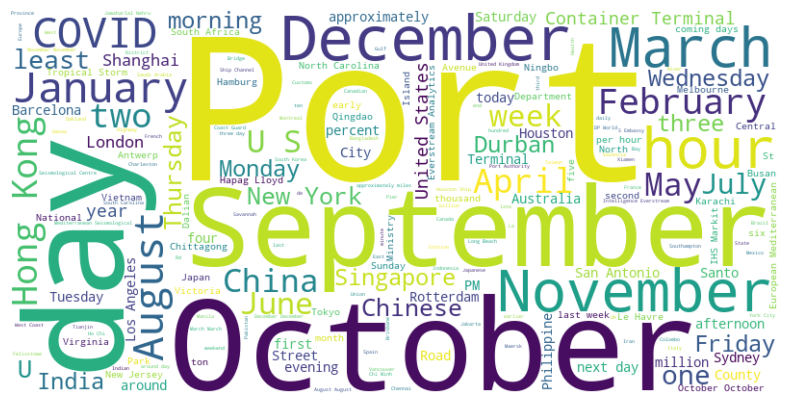

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all the documents into a single string
text = " ".join(documents)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()